In [29]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

## STEP 1: Load and Explore Data

In this project, I will be working with the RFM dataframe that I created in another [project](https://github.com/k-bosko/RFM_analysis) based on real data from online retail store.

In [2]:
rfm_table = pd.read_csv("rfm_table.csv")

In [3]:
rfm_table.head()

,Customer ID,Recency,Frequency,Monetary Value,R,F,M,RFM_Segment,RFM_Score,Custom_Segment
0,12346.0,325,2,0.00,1,2,1,121,4.0,3_Low
1,12347.0,1,6,3598.21,4,4,4,444,12.0,1_Top
2,12348.0,74,3,784.44,2,2,3,223,7.0,2_Middle
3,12349.0,18,1,1457.55,3,1,3,313,7.0,2_Middle
4,12350.0,309,1,294.40,1,1,2,112,4.0,3_Low


In [4]:
# we will be working with just the Recency, Frequency and Monetary Value as columns
rfm = rfm_table.iloc[:, 1:4]

In [5]:
# we will also need Customer ID as index
rfm.index = rfm_table['Customer ID']

In [6]:
rfm.head()

,Recency,Frequency,Monetary Value
Customer ID,,,
12346.0,325,2,0.00
12347.0,1,6,3598.21
12348.0,74,3,784.44
12349.0,18,1,1457.55
12350.0,309,1,294.40


## Step 2: Data Pre-Processing

### Log Transform

K-means clustering assumes that all variables have comparable means and variance. Otherwise, the algorithm will assign more weight to some variable, which we don't want to happen. So before applying k-means clustering, we need to make sure that our data is not skewed, which we do through visualization via a histogram.

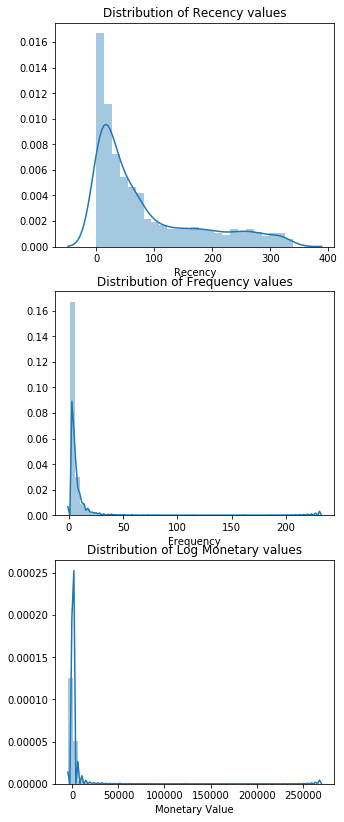

In [7]:
plt.figure(figsize=(5,14))

plt.subplot(3, 1, 1);
plt.title("Distribution of Recency values")
sns.distplot(rfm['Recency']);

plt.subplot(3, 1, 2);
plt.title("Distribution of Frequency values")
sns.distplot(rfm['Frequency']);

plt.subplot(3, 1, 3);
plt.title("Distribution of Log Monetary values")
sns.distplot(rfm['Monetary Value']);

Note: from histograms above, we can conclude that our data is skewed and we need to apply log transform to remove skewness. 

In [8]:
# log transform cannot be applied when we have 0s. checking this condition:
(rfm == 0).sum(axis=0)

Recency           105
Frequency           0
Monetary Value      9
dtype: int64

In [9]:
# log transform cannot be applied when we have negative values. checking this condition:
(rfm < 0).sum(axis=0)

Recency            0
Frequency          0
Monetary Value    32
dtype: int64

In [10]:
# we will deal with 0s by adding a small constant
rfm['Recency'] = rfm['Recency'] + 0.001

In [11]:
# we will deal with negative values by adding the absolute value of the biggest negative value and then
# add a small constant to make sure it's not 0
rfm['Monetary Value'] = rfm['Monetary Value'] + abs(rfm['Monetary Value'].min()) + 0.001

In [12]:
# checking results of transformation
(rfm == 0).sum(axis=0), (rfm < 0).sum(axis=0)

(Recency           0
 Frequency         0
 Monetary Value    0
 dtype: int64, Recency           0
 Frequency         0
 Monetary Value    0
 dtype: int64)

In [13]:
rfm_log = np.log(rfm)

## Centering and Scaling

In [14]:
rfm_log.describe()

,Recency,Frequency,Monetary Value
count,4244.000000,4244.000000,4244.000000
mean,3.432410,1.033532,8.605526
std,2.166525,0.935669,0.406375
min,-6.907755,0.000000,-6.907755
25%,2.708117,0.000000,8.428579
50%,3.806685,1.098612,8.501331
75%,4.836290,1.609438,8.671192
max,5.826003,5.442418,12.521528


Note: Recency, Frequency and Monetary means and standard deviations are on different scale. We need to apply standard scaler (substract the mean from each observation and divide by standard deviation) so that all variables would have 0 mean and 1 as standard deviation. 

In [21]:
scaler = StandardScaler()
rfm_normalized = scaler.fit_transform(rfm_log)

In [22]:
# checking scaling results
print(f"after scaling means: {rfm_scaled.mean(axis=0).round(1)}, std: {rfm_scaled.std(axis=0)}")

after scaling means: Recency           0.0
Frequency         0.0
Monetary Value   -0.0
dtype: float64, std: Recency           1.000118
Frequency         1.000118
Monetary Value    1.000118
dtype: float64


In [23]:
rfm_normalized = pd.DataFrame(rfm_scaled, index=rfm.index, columns=rfm.columns)

In [24]:
rfm_normalized.head()

,Recency,Frequency,Monetary Value
Customer ID,,,
12346.0,1.085469,-0.363830,-0.595668
12347.0,-1.584018,0.810454,0.903945
12348.0,0.402382,0.069563,-0.182172
12349.0,-0.250192,-1.104721,0.124507
12350.0,1.062164,-1.104721,-0.432234


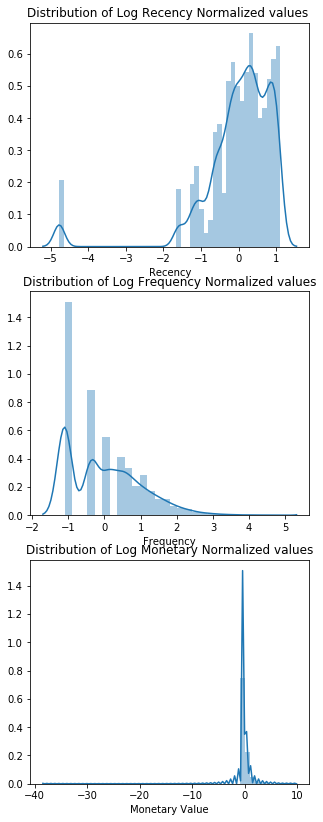

In [25]:
plt.figure(figsize=(5,14))

plt.subplot(3, 1, 1);
plt.title("Distribution of Log Recency Normalized values ")
sns.distplot(rfm_normalized['Recency']);

plt.subplot(3, 1, 2);
plt.title("Distribution of Log Frequency Normalized values")
sns.distplot(rfm_normalized['Frequency']);

plt.subplot(3, 1, 3);
plt.title("Distribution of Log Monetary Normalized values")
sns.distplot(rfm_normalized['Monetary Value']);

## Step 3: k-means Clustering

We will use elbow method to decide how many clusters to use. 
Elbow method plots the number of clusters against the within-cluster sum of squared errors (SSE) - sums of squared distances from each point to the cluster center. We will see kind of an elbow where the descrease in SSE slows down - this will the optimal number of clusters to use.

In [71]:
range_n_clusters = range(1,11)
sse = {}

# for 10 different clusters
for k in range_n_clusters:
    # fit clusterer
    kmeans = KMeans(n_clusters=k, random_state=1023)
    kmeans.fit(rfm_normalized)
    # compute the average within-cluster distance (sse) for each cluster 
    sse[k] = kmeans.inertia_
    print(f"sse for {k} cluster: {kmeans.inertia_.round(1)}")

sse for 1 cluster: 12732.0
sse for 2 cluster: 7879.2
sse for 3 cluster: 5971.3
sse for 4 cluster: 4541.2
sse for 5 cluster: 3392.3
sse for 6 cluster: 2747.9
sse for 7 cluster: 2340.9
sse for 8 cluster: 1988.4
sse for 9 cluster: 1780.7
sse for 10 cluster: 1592.7


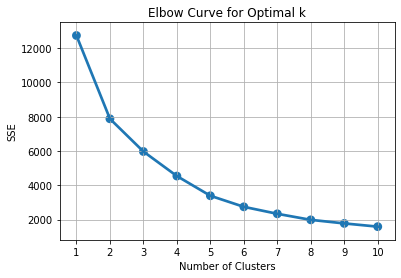

In [73]:
plt.title("Elbow Curve for Optimal k")
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.xlabel('Number of Clusters')
plt.ylabel('SSE')
plt.grid();

Note: based on Elbow method, we can see from the plot that there's an "elbow" around 2 clusters. I will test 2 and 3 clusters to see which results provide more business insights.

In [80]:
def cluster_me(n, df_normalized):
    '''
    Clusters using KMeans
    Input:
        n: number of clusters to be used
        df_normalized: dataframe with normalized values
    Output:
        rfm_n: rfm with added new column with clustering results
    '''
    kmeans = KMeans(n_clusters=n, random_state=1023)
    kmeans.fit(df_normalized)
    #extract cluster labels
    cluster_labels = kmeans.labels_
    
    #add new column to original rfm (without transformations)
    rfm_n = rfm.assign(Cluster = cluster_labels)
    return rfm_n

In [135]:
rfm_k2 = cluster_me(2, rfm_normalized)
rfm_k3 = cluster_me(3, rfm_normalized)

In [131]:
rfm_k2.groupby(['Cluster']).agg({'Recency': 'mean', 'Frequency': 'mean', 'Monetary Value': ['mean', 'count']}).round(1)

Recency Frequency Monetary Value      
           mean      mean           mean count
Cluster                                       
0         121.3       1.7         4734.4  2500
1          27.9       9.3         8035.7  1744

In [136]:
rfm_k3.groupby(['Cluster']).agg({'Recency': 'mean', 'Frequency': 'mean', 'Monetary Value': ['mean', 'count']}).round(1)

Recency Frequency Monetary Value      
           mean      mean           mean count
Cluster                                       
0         121.3       1.7         4734.4  2499
1           1.6      26.9        22090.9   159
2          30.6       7.5         6624.6  1586

**Conclusion**: from technical standpoint, 2 clusters are distinct, while 3 clusters are unequal in terms of their size. From business point of view, I think it's better to keep 3 clusters because it provides more insight. It seems like there are 159 customers (probably wholesalers) in Cluster 1 who buy a lot from us pretty frequent. These are our core business clients. 

## Snake Plot

In [137]:
rfm_normalized['Cluster'] = rfm_k3['Cluster']

In [138]:
rfm_normalized_melt = pd.melt(rfm_normalized.reset_index(), id_vars=['Customer ID', 'Cluster'], 
                              value_vars=['Recency', 'Frequency', 'Monetary Value'],
                             var_name='Metric', value_name='Value')

In [139]:
rfm_normalized_melt.head()

,Customer ID,Cluster,Metric,Value
0,12346.0,0,Recency,1.085469
1,12347.0,2,Recency,-1.584018
2,12348.0,0,Recency,0.402382
3,12349.0,0,Recency,-0.250192
4,12350.0,0,Recency,1.062164


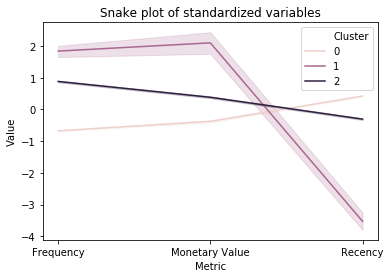

In [140]:
plt.title("Snake plot of standardized variables");
sns.lineplot(x='Metric', y='Value', hue='Cluster', data=rfm_normalized_melt);

**Conclusion**: the snake plot makes the distinction between 3 Clusters more intuitive - there is Cluster 1 with customers that spend the most, buy most frequently and most recently. The next good segment is Cluster 2 and the least attractive Cluster 0.

## Relative importance of segment variables

In [141]:
cluster_avg = rfm_k3.groupby(['Cluster']).mean()
cluster_avg

,Recency,Frequency,Monetary Value
Cluster,,,
0,121.256702,1.667467,4734.392794
1,1.623642,26.924528,22090.889302
2,30.644758,7.498739,6624.603006


In [142]:
population_avg = rfm.mean()
population_avg

Recency             82.912640
Frequency            4.792884
Monetary Value    6091.027181
dtype: float64

In [143]:
# subtract 1 ensures that 0 is returned if cluster_avg=population_avg
relative_importance = (cluster_avg/population_avg - 1).round(2)
relative_importance

,Recency,Frequency,Monetary Value
Cluster,,,
0,0.46,-0.65,-0.22
1,-0.98,4.62,2.63
2,-0.63,0.56,0.09


Note: the futher the ratio is from 0, the more important that variable is for the segment relative to the total population. 

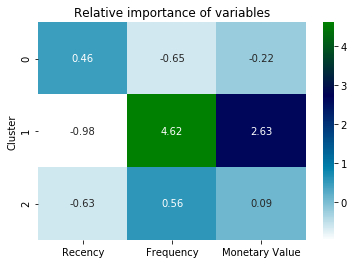

In [144]:
plt.title("Relative importance of variables");
sns.heatmap(relative_importance, annot=True, fmt='.2f', cmap='ocean_r');

**Conclusion**: we see that Frequency and Monetary Value are the most important metrics of Cluster 1, where our core clients are. Frequency is more important for the 2nd best group of clients in Cluster 2, while Recency - for Cluster 0.

## Credentials:

**Data Source:** Online Retail II Data Set, UCI Machine Learning Repository, http://archive.ics.uci.edu/ml/datasets/Online+Retail+II

Analysis done after completing the course "Customer Segmentation in Python" on DataCamp (instructor - 
Karolis Urbonas)